In [1]:
import sys
import os

In [2]:
from importer import *
from utils import *

## Prep

In [3]:
CLIPS_ROOT = raw_clip_data
SAVE_ROOT = os.path.join(save_clip_data, 'mask_pose')
SAVE_ROOT

'/media/haruyaishikawa/new_disk/save_clip_data/mask_pose'

In [4]:
events = [event_names[i] for i in event_ids]
events

['meal time',
 'meeting',
 'coffee break',
 'nap',
 'cooking',
 'working',
 'tending to plants']

In [5]:
event = events[4]
clip_id = 2

In [6]:
dm = ShortClipManagement(event, CLIPS_ROOT, SAVE_ROOT)
clips = dm.change_event(event)

Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [7]:
clip = clips[clip_id]
rgb_images = dm.get_sorted_rgb_images(clip)

In [8]:
manager = ClipsSavedDataManagement(event=event, root_path=SAVE_ROOT)
clips = manager.change_event(event)

Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [9]:
clip = clips[clip_id]  # choose first clip

In [11]:
all_files = manager.get_sorted_npz_files(clip)
# files
print(len(all_files))
print(all_files[0])

762
0.npz


In [11]:
# starting point of clip
init = 200

length = len(all_files)
splits = 4
seg = int(length//splits)
print('segemnts: ', seg)

files = all_files[init:init+seg]

segemnts:  190


## Test mapping

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
from eventmap import *

mappingtool = MappingTool()

### Poses

In [14]:
def process_body_part(pose, joints):
    '''
    return pointfor joints body part given joints
    joints = [array of joint values]
    '''
    # initialize
    points = np.empty((len(joints), 3))
    points[:] = np.nan
    
    for i, joint in enumerate(joints):
        point = pose[joint]
        
        if (point == [0,0,0]).all():
            continue
        
        points[i] = pose[joint]
        
    # change axis
    points = np.rollaxis(points, 1)
        
    return points

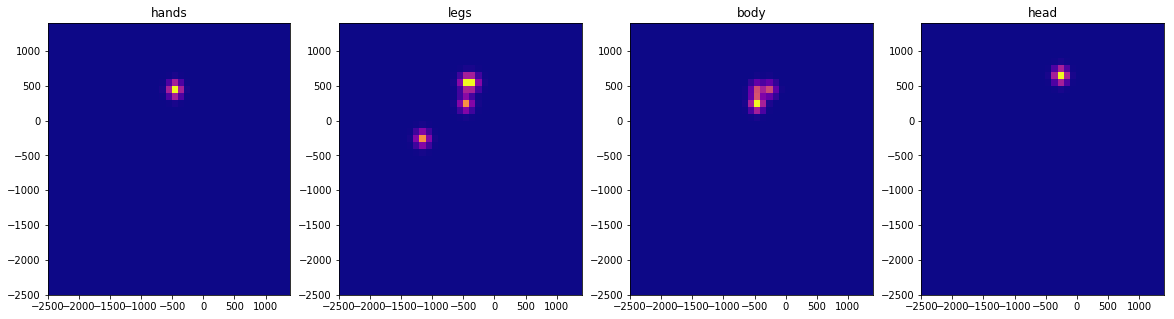

In [15]:
file = files[0]

# get poses
filename = os.path.join(manager.get_clip_directory(clip), file)
poses, _ = poses_masks_from_npz(filename)

# Figure for visualization
fig, axs = plt.subplots(1, len(eventmap_pose_dict), 
                        figsize=(20, 5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(mappingtool.xedges, mappingtool.yedges)

single_pose_averages = {}

# initialize pose averages
for name, value in eventmap_pose_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = mappingtool.single_histogram(points)
    
    single_pose_averages[name] = H

# multiple people
if not(poses is None):
    for i, pose in poses.items():
        # for each people
        for name, joints in eventmap_pose_dict.items():

            points = process_body_part(pose, joints)
            H = mappingtool.single_histogram(points)

            single_pose_averages[name] += H


# plot
for name, H in single_pose_averages.items():
    H = mappingtool.normalize(H)
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1

### Objects

In [16]:
def process_object(points):
    points = np.rollaxis(points, 1)
    return points

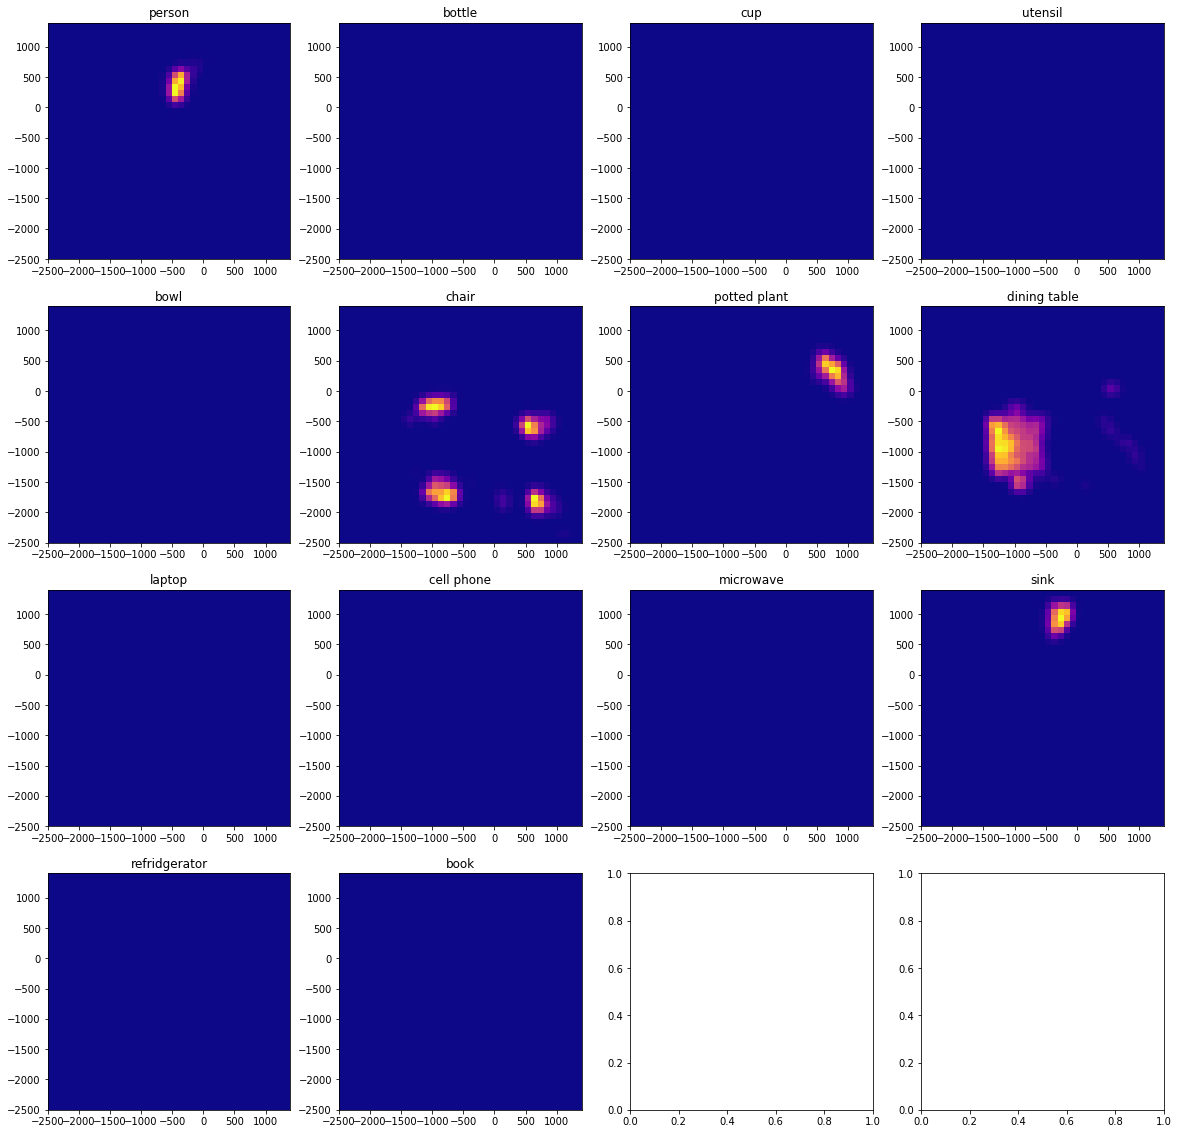

In [17]:
file = files[0]

# get masks
filename = os.path.join(manager.get_clip_directory(clip), file)
_, masks = poses_masks_from_npz(filename)

# Figure for visualization
rows = 3
fig, axs = plt.subplots(rows+1, len(eventmap_object_dict)//rows, 
                        figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(mappingtool.xedges, mappingtool.yedges)

single_object_averages = {}

# initialize pose averages
for name, value in eventmap_object_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = mappingtool.single_histogram(points)
    
    single_object_averages[name] = H


# get data
for mask in masks:
    
    object_id = int(mask.split('_')[0])
    
    for object_name, object_ids in eventmap_object_dict.items():
        if object_id in object_ids:
            mask = masks[mask]

            points = process_object(mask)
            H = mappingtool.single_histogram(points)
                
            single_object_averages[object_name] += H


# plot
for name, H in single_object_averages.items():
    H = mappingtool.normalize(H)
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 

## Test foor multiple files

In [18]:
object_averages = {}

# initialize pose averages
points = np.empty((3, 1))
points[:] = np.nan
H = mappingtool.single_histogram(points)

for name, value in eventmap_object_dict.items():
    object_averages[name] = H.copy()
    

count = 0
    
# iterate through all files
for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    _, masks = poses_masks_from_npz(filename)
    
    if masks is None:
        continue
    
    for mask in masks:
    
        object_id = int(mask.split('_')[0])

        for object_name, object_ids in eventmap_object_dict.items():
            if object_id in object_ids:
                mask = masks[mask]

                points = process_object(mask)
                H = mappingtool.single_histogram(points)

                object_averages[object_name] += H
            
        count += 1

print(f'# of masks: {count}')

# of masks: 1513


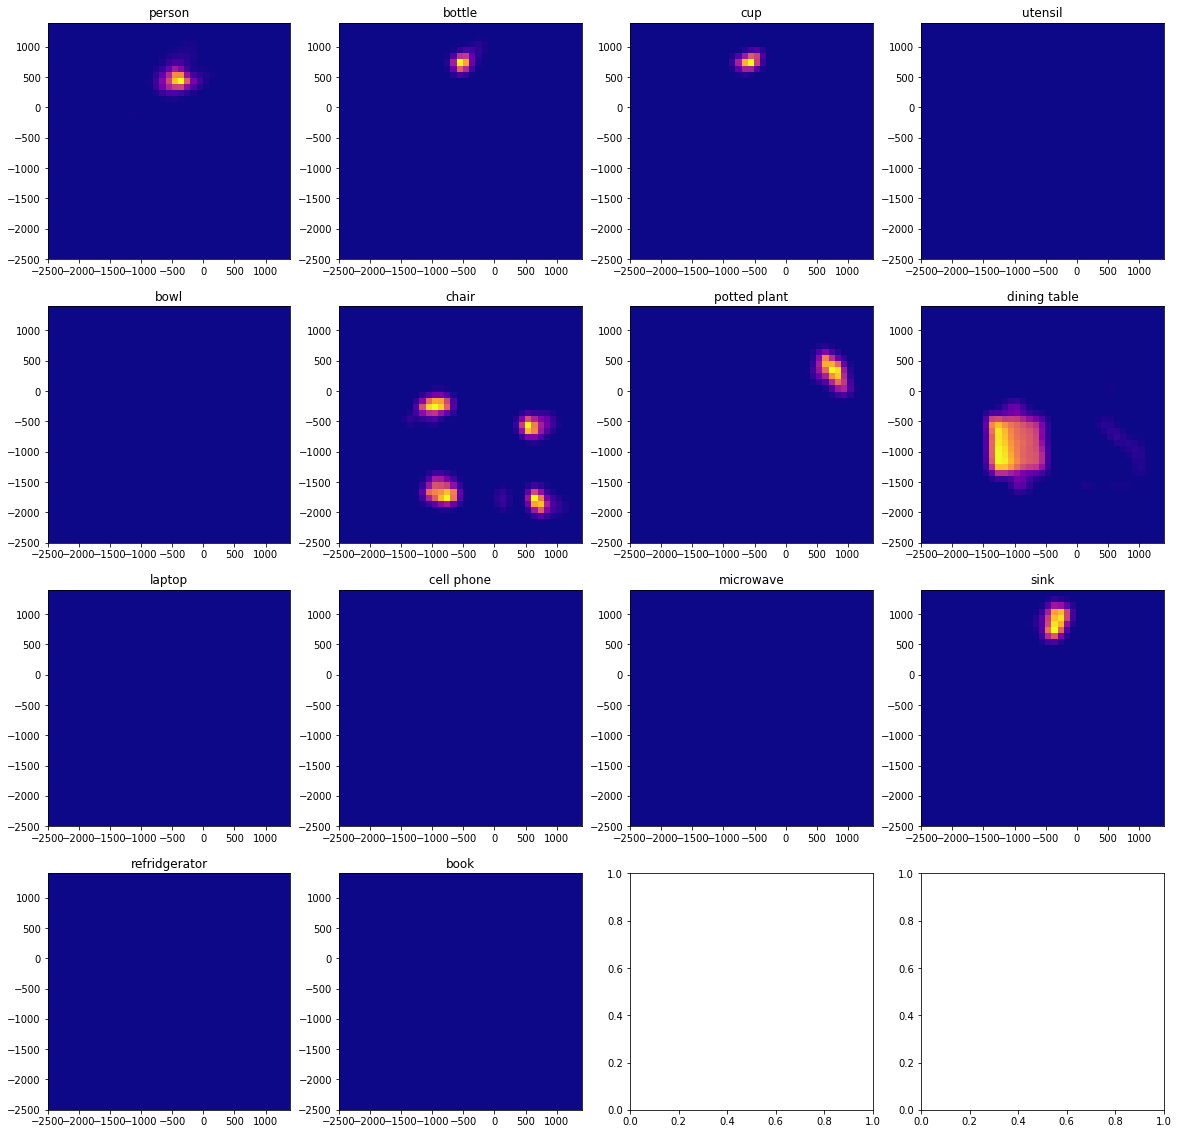

In [19]:
# Figure for visualization
rows = 3
fig, axs = plt.subplots(rows+1, len(eventmap_object_dict)//rows, 
                        figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(mappingtool.xedges, mappingtool.yedges)

for name, H in object_averages.items():
    # normalize
    H = mappingtool.normalize(H)
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 